In [15]:
import keras
from keras.layers import Input, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
x_train = np.load("data/all_input.npy").astype(np.float32)
y_train = np.load("data/all_output.npy").astype(np.float32)
print ('x_train', x_train.shape) #320000 x 128 x 128: 128 -- size of maps, 3200000: number data points

np.save("data/small_input.npy", x_train[:300,:,:])
np.save("data/small_output.npy", y_train[:300,:,:])

# x_train = np.load("data/small_input.npy").astype(np.float32)
# y_train = np.load("data/small_output.npy").astype(np.float32)

n_train = 20000
N = x_train.shape[1]
x_train = x_train[:n_train, :, :]
y_train = y_train[:n_train, :, :]

x_train (22400, 64, 64)


In [2]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

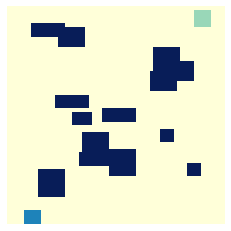

In [3]:
ax = sns.heatmap(x_train[0].T, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, square=True)

In [6]:
import tensorflow as tf
x = Input(shape=(N, N, 1))

net = Conv2D(filters=64, kernel_size=[3, 3], strides=[1, 1], padding="same", kernel_initializer='orthogonal', activation='relu')(x)
net = BatchNormalization()(net)
for i in range(11):
# for i in range(10):
    net = Conv2D(filters=64, kernel_size=[3, 3], strides=[1, 1], padding="same", kernel_initializer='orthogonal', activation='relu')(net)
    net = BatchNormalization()(net)

net = Conv2D(filters=1, kernel_size=[3, 3], strides=[1, 1], padding="same", kernel_initializer='orthogonal', activation='sigmoid')(net)
net = BatchNormalization()(net)	
net = Dropout(0.10)(net)

model = Model(inputs=x,outputs=net)
model.summary()

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
# save_weights = ModelCheckpoint(filepath='weights_2d.hf5', monitor='val_acc',verbose=1, save_best_only=True)

print('Train network ...')
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse',metrics=['accuracy'])

# model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
model.fit(x_train.reshape(n_train,N,N,1), y_train.reshape(n_train,N,N,1), batch_size=64, validation_split=1/14, epochs=30, verbose=1)
print('Save trained model ...')
model.save("model_2d_21.hf5")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 batch_normalization_24 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_25 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 64)        3692

2022-02-14 23:54:50.242984: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_2d_21.hf5/assets


In [16]:
import os.path as op
model = load_model("model_2d_21.hf5")
arr_dir = "/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array"
train_paths = np.load(op.join(arr_dir, "train_path.npy"))
maz = np.load(op.join(arr_dir, "maz.npy"))
maz = np.rint(maz/255.0)
# maz = maz * 2 - 1 #convert the value range [0, 1] to [-1, 1]

print ('maz', maz.shape)
print ('train_paths', train_paths.shape)

maz (120, 64, 64)
train_paths (160000, 16, 2)


In [17]:
for i in range(10):
    print (train_paths[i,0], train_paths[i, -1] )

[57  3] [ 7 62]
[ 7 60] [56  0]
[59  3] [ 0 58]
[ 0 61] [55  8]
[13  2] [57 62]
[53  5] [ 1 60]
[61  2] [11 62]
[ 6 12] [58 62]
[60  3] [13 57]
[10 59] [55  2]


In [18]:
def augment_state(aug_state, curr_maz, v):
    radius = 1
    for row in range(aug_state[0]-radius, aug_state[0]+radius+1):
        for col in range(aug_state[1]-radius, aug_state[1]+radius+1):
            if 0 <= row < N and 0 <= col < N and curr_maz[0, row, col, 0]!= 1:
                curr_maz[0, row, col, 0] = v
    return curr_maz

In [19]:
def collision_detection(state1, state2, curr_maz): #curr_maz shape: (1, N, N , 1)
    distance = np.sqrt(np.sum(np.square(state1 - state2)))
    check_interval = 0.05
    check_num = int(distance//check_interval)
    x = np.linspace(state1[0], state2[0], check_num)
    y = np.linspace(state1[1], state2[1], check_num)
#     print (x.shape)
    for i in range(x.shape[0]):
        if curr_maz[0, int(x[i]), int(y[i]), 0] == 1.0:
            return True
    return False
    

In [20]:
def reach_goal(state1, state2): #state1 in the region of state2
    region_radius = 3
    if np.sum(np.absolute(state1-state2))<=3:
        return True
    else:
        return False
    

In [1]:
#Path Construction
import tensorflow as tf
import time
maz_id = 0
path_id = 400
max_itr = 200
start_v = 0.33
goal_v = 0.66
workspace = np.copy(maz[maz_id])
all_paths = []
all_iterations = []
all_times = []
start_time = time.time()
for maze_id in range(100):
    for path_id in range(1500, 2000):



        # init_state = np.copy(train_configs[maz_id, path_id])
        curr_state = train_paths[maz_id * 1600 + path_id, 0]
        goal_state = train_paths[maz_id * 1600 + path_id, -1]

        #environments with augmented goal state and w/o start state
        workspace = workspace.reshape(1,N,N,1)
        img_task = augment_state(goal_state, np.copy(workspace), goal_v) 


        #update the curr_task with respect to the robot state
        curr_task = augment_state(curr_state, np.copy(img_task), start_v)
        path = [curr_state]

        for i in range(max_itr):
            pred_prob = model(curr_task)
            pred_sample = np.unravel_index(np.argsort(pred_prob[0,:,:,0], axis=None)[::-1], (N,N))
        #     pred_sample = tf.argsort(pred_prob[0,:,:,0], direction="DESCENDING")
            pred_sample = np.stack(pred_sample, axis=-1)

            for s in pred_sample:
                flag = False
                for p in path: #check the waypoint already exists in the path
                    if p[0] == s[0] and p[1] == s[1]:
                        flag = True
                        break

                if not collision_detection(path[-1], s, workspace) and not flag:#if no collision and not used
                    path.append(s)
                    curr_task = augment_state(s, np.copy(img_task), start_v)
                    break
            if reach_goal(path[-1], goal_state):
                path.append(goal_state)
                break
        print ('path', path)
        if (path[-1] == goal_state).all():
            all_paths.append(path)
            print ('success', path_id)
        else:
            all_paths.append([])
            print ('fail', path_id)

        all_iterations.append(i)
        all_times.append(time.time()-start_time)
    
print ('the time cost', time.time()-start_time)
    
    
    
    
    

ModuleNotFoundError: No module named 'tensorflow'

In [2]:

success = 0
min_len = np.inf
min_idx = 0
for i in range(len(all_paths)):
    if len(all_paths[i]) > 0:
        success += 1
        if len(all_paths[i]) < min_len:
            min_len = len(all_paths[i])
            min_idx = i
        
print ('success rate', success/50)
print ('avg ite', sum(all_iterations)/50)
print ('avg time', sum(all_times)/50)
print ('min idx', min_idx)
print ('min len', min_len)

NameError: name 'np' is not defined

In [384]:
vis_id = 40
path = np.array(all_paths[vis_id])
print (path)

[[59 13]
 [54 44]
 [53 45]
 [ 2 62]
 [ 1 60]]


/tmp/ipykernel_990192/1549701876.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x,y, 'ro-', color='blue')
/tmp/ipykernel_990192/1549701876.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x[0], y[0], 'ro', color='green')
/tmp/ipykernel_990192/1549701876.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x[-1], y[-1], 'ro', color='red')


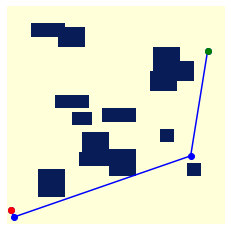

In [387]:
# path = [[ 9, 62],[54, 44],[57,  24],[60,  8]]
# path = [[14,  2], [17,  3], [17,  4], [19,  4], [22,  3], [55, 58], [58, 60]]
path = [path[i] for i in [0,1,3,4]]

# plt.imshow(test_seen_video[map_id,task_id,0])
vis_env = workspace[0,:,:,0]
# plt.imshow(vis_env.T)
sns.heatmap(vis_env.T, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, square=True)

plt.axis('off')
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
x = [x for x,y in path]
y = [y for x,y in path]
plt.plot(x,y, 'ro-', color='blue')

plt.plot(x[0], y[0], 'ro', color='green')
plt.plot(x[-1], y[-1], 'ro', color='red')

plt.show()




<AxesSubplot:>

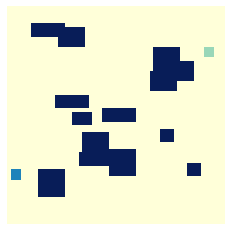

In [436]:
# node 0
curr_task = augment_state(path[0], np.copy(img_task), start_v)
sns.heatmap(curr_task[0,:,:,0].T, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, square=True)

<AxesSubplot:>

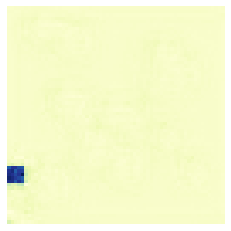

In [430]:
output1 = model(curr_task)
output1 = np.array(output1[0,:,:,0])
# sns.heatmap(vis_env.T, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, square=True)
# plt.axis('off')
# plt.imshow(output1.T)
sns.heatmap(output1.T, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, square=True)

<AxesSubplot:>

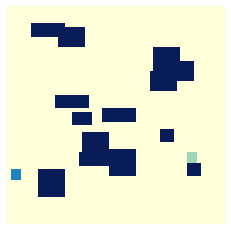

In [437]:
# node 1
curr_task = augment_state(path[1], np.copy(img_task), start_v)
sns.heatmap(curr_task[0,:,:,0].T, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, square=True)

<AxesSubplot:>

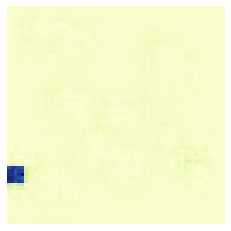

In [438]:
output1 = model(curr_task)
output1 = np.array(output1[0,:,:,0])
# sns.heatmap(vis_env.T, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, square=True)
# plt.axis('off')
# plt.imshow(output1.T)
sns.heatmap(output1.T, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, square=True)

<AxesSubplot:>

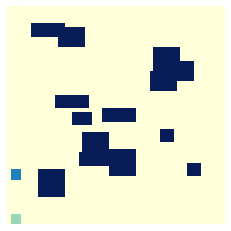

In [433]:
# node 2
curr_task = augment_state(path[2], np.copy(img_task), start_v)
sns.heatmap(curr_task[0,:,:,0].T, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, square=True)

<AxesSubplot:>

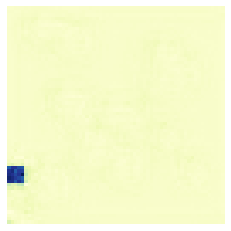

In [434]:
output1 = model(curr_task)
output1 = np.array(output1[0,:,:,0])
# sns.heatmap(vis_env.T, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, square=True)
# plt.axis('off')
# plt.imshow(output1.T)
sns.heatmap(output1.T, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False, square=True)